<a href="https://colab.research.google.com/github/Ian-costermani/DS/blob/main/C%C3%B3pia_de_leilao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto   detecção fraude em leilões  -                Hackaton 01 FCCD    ❗🤖**

---



Nesta competição nos aprofundamos nos dados de um mercado digital, onde ocorre simultaneamente diversos leilões online, no entanto, nem todos os jogadores neste campo são humanos, alguns são robôs programados para manipular os resultados dos leilões.Sendo assim, este projeto visa a criação de um modelo que tenta diferenciar bem lances feitos por humanos de lances feitos por robôs.



---
O notebook está dividido em:



1.   Importação das bibliotecas
2.   Separação dos dados de treino e dados de teste

1.   Feature Engineering / Processamento dos dados
2.   Desenvolvimento dos modelos

1.   Métricas de validação






In [241]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- **Importando as bibliotecas**

In [ ]:
!pip install category_encoders

In [ ]:
pip install optuna

In [244]:
from category_encoders import TargetEncoder
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score ,f1_score ,make_scorer,confusion_matrix, ConfusionMatrixDisplay,roc_curve, roc_auc_score, brier_score_loss, confusion_matrix
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pandas as pd

- **Importando e separando os dados**

In [245]:

df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
df_lances = pd.read_csv('/content/drive/MyDrive/lances.csv')

In [246]:
# Split entre treino e teste para validacao

df_train_shuffled = df_train.sample(frac=1, random_state=19)

df_treino = df_train_shuffled.iloc[:1000, :]
df_treino_Test = df_train_shuffled.iloc[1000:, :]


In [247]:
# Pegando os dados de todos lances dos nossos participantes da tabela treino
df_train_lances = df_lances.merge(df_treino, on='id_participante',how='right')
df_train_lances

,id_lance,id_participante,leilao,mercadoria,dispositivo,tempo,pais,ip,url,conta_pagamento,endereco,resultado
0,2356531.0,975dd5178d34453c1c3c8edc47cf44274uv5s,o4c97,joias,phone75,9.631939e+15,Índia,20.89.78.130,2nure808ml6plu2,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0
1,2359167.0,975dd5178d34453c1c3c8edc47cf44274uv5s,o4c97,joias,phone26,9.631943e+15,Índia,8.253.229.117,5vegxz4qm47umrh,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0
2,2364855.0,975dd5178d34453c1c3c8edc47cf44274uv5s,7o07e,joias,phone45,9.631954e+15,Índia,19.95.120.49,shpinveqtigrb4j,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0
3,2366146.0,975dd5178d34453c1c3c8edc47cf44274uv5s,cxlov,joias,phone57,9.631956e+15,Índia,152.54.151.219,ram5hpwimadwwtq,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0
4,2371701.0,975dd5178d34453c1c3c8edc47cf44274uv5s,l20tl,joias,phone57,9.631966e+15,Índia,36.220.149.150,xa5k4cdmuahgf2r,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2162671,2499084.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,jqx39,joias,phone94,9.632291e+15,Índia,134.99.6.45,03hcz8g2fo91i7z,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0
2162672,2734315.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,opnq4,joias,phone25,9.633239e+15,Nigéria,212.146.226.103,hj9xxwoc2qfnxdc,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0
2162673,3094372.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,jqx39,joias,phone91,9.635601e+15,Índia,56.64.200.34,03hcz8g2fo91i7z,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0
2162674,3094597.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,jqx39,joias,phone91,9.635602e+15,Índia,56.64.200.34,03hcz8g2fo91i7z,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0


In [248]:
# Pegando os dados de todos lances dos nossos participantes da tabela teste
df_test_lances = df_lances.merge(df_treino_Test, on='id_participante',how='right')
df_test_lances

,id_lance,id_participante,leilao,mercadoria,dispositivo,tempo,pais,ip,url,conta_pagamento,endereco,resultado
0,2357915.0,332484ddd66b9a3db89ee68f08b1288amq90u,rp76w,artigos esportivos,phone4,9.631941e+15,Índia,216.197.201.221,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0
1,2358473.0,332484ddd66b9a3db89ee68f08b1288amq90u,rp76w,artigos esportivos,phone4,9.631942e+15,Índia,216.197.201.221,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0
2,2359911.0,332484ddd66b9a3db89ee68f08b1288amq90u,rp76w,artigos esportivos,phone4,9.631945e+15,Índia,216.197.201.221,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0
3,2402229.0,332484ddd66b9a3db89ee68f08b1288amq90u,ny7pv,artigos esportivos,phone3,9.632027e+15,Índia,128.52.56.91,2698n9qkv01zghq,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0
4,2425973.0,332484ddd66b9a3db89ee68f08b1288amq90u,l20tl,artigos esportivos,phone4,9.632086e+15,Índia,2.94.45.211,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0
...,...,...,...,...,...,...,...,...,...,...,...,...
371660,2350526.0,d2704c8bb6ebbf13e08f37131382b126wy4yc,g26sr,móveis,phone41,9.772882e+15,Índia,106.130.159.32,n7hs0kmoakimcyr,308f53abff7d25a618069ec8b74feecexmpf3,a3d2de7675556553a5f08e4c88d2c228djz03,1
371661,2350774.0,d2704c8bb6ebbf13e08f37131382b126wy4yc,c64op,móveis,phone4,9.772883e+15,Índia,197.222.226.196,vasstdc27m7nks3,308f53abff7d25a618069ec8b74feecexmpf3,a3d2de7675556553a5f08e4c88d2c228djz03,1
371662,2350990.0,d2704c8bb6ebbf13e08f37131382b126wy4yc,7n6dw,móveis,phone20,9.772884e+15,Índia,185.77.229.241,6kw3cjzj4g1k9gv,308f53abff7d25a618069ec8b74feecexmpf3,a3d2de7675556553a5f08e4c88d2c228djz03,1
371663,777819.0,6b85d622dec4fff284d55895eba9969dqlhu9,4ksf7,móveis,phone168,9.763821e+15,ae,56.54.33.87,01sz3a2qfvl1xb0,a23e590aef8273164bcff0fc02d974e5jjd8r,a3d2de7675556553a5f08e4c88d2c228d0wfr,0


In [249]:
df_test_lances['resultado'].value_counts()

resultado
0    304948
1     66717
Name: count, dtype: int64

- **Feature Engineering / Pré-processamento dos dados**

Nesta etapa é feita o tratamento das colunas categóricas onde se foi preferido utilizar o método de Target encoder. Além disso testamos alguns insights de features que poderiam ajudar nosso modelo, como por exemplo:




*   De quantos países diferentes esse participante já deu lances?
*   Quantos ips diferentes esse participante deu lances?


*   Time Flag - verifica se o participante tentou dar mais de um lance no mesmo exato momento

*   Qual costuma ser o intervalo de tempo entre um lance e outro desse participante?

*   Quantas lances ele faz para cada troca de ip?
*   Quantos lances ele faz para cada troca de dispositivo?


*   Quantos ips ele usa por país


*   **...**






In [250]:
categorical_features = ['leilao', 'mercadoria', 'dispositivo', 'pais', 'ip', 'url']

In [251]:
pesos =['peso_leilao', 'peso_mercadoria', 'peso_dispositivo', 'peso_pais', 'peso_ip', 'peso_url']

In [252]:
encoder= TargetEncoder(min_samples_leaf=450,smoothing=11.5,cols=categorical_features)

In [253]:
encoder.fit(df_train_lances[categorical_features],df_train_lances['resultado'])

TargetEncoder(cols=['leilao', 'mercadoria', 'dispositivo', 'pais', 'ip', 'url'],
              min_samples_leaf=450, smoothing=11.5)

In [254]:
df_train_lances[pesos] = encoder.transform(df_train_lances[categorical_features])
df_test_lances[pesos] = encoder.transform(df_test_lances[categorical_features])

In [ ]:
df_train_lances

In [256]:
# adicionando a coluna time_flag nos dados de treino
grouped_df = df_train_lances.groupby(['id_participante', 'tempo'])

df_train_lances['time_flag'] = grouped_df['tempo'].transform('count')
df_train_lances


,id_lance,id_participante,leilao,mercadoria,dispositivo,tempo,pais,ip,url,conta_pagamento,endereco,resultado,peso_leilao,peso_mercadoria,peso_dispositivo,peso_pais,peso_ip,peso_url,time_flag
0,2356531.0,975dd5178d34453c1c3c8edc47cf44274uv5s,o4c97,joias,phone75,9.631939e+15,Índia,20.89.78.130,2nure808ml6plu2,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0,0.123310,0.016825,0.039436,0.157033,0.123310,0.12331,1.0
1,2359167.0,975dd5178d34453c1c3c8edc47cf44274uv5s,o4c97,joias,phone26,9.631943e+15,Índia,8.253.229.117,5vegxz4qm47umrh,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0,0.123310,0.016825,0.039265,0.157033,0.123310,0.12331,1.0
2,2364855.0,975dd5178d34453c1c3c8edc47cf44274uv5s,7o07e,joias,phone45,9.631954e+15,Índia,19.95.120.49,shpinveqtigrb4j,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0,0.081272,0.016825,0.028179,0.157033,0.123310,0.12331,1.0
3,2366146.0,975dd5178d34453c1c3c8edc47cf44274uv5s,cxlov,joias,phone57,9.631956e+15,Índia,152.54.151.219,ram5hpwimadwwtq,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0,0.008034,0.016825,0.029105,0.157033,0.052381,0.12331,1.0
4,2371701.0,975dd5178d34453c1c3c8edc47cf44274uv5s,l20tl,joias,phone57,9.631966e+15,Índia,36.220.149.150,xa5k4cdmuahgf2r,be0aa2520de962e5296a6d502232dcf44yhl7,2afd0c1fe23742a87d60ef83d308363bxhosq,0,0.007419,0.016825,0.029105,0.157033,0.123310,0.12331,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162671,2499084.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,jqx39,joias,phone94,9.632291e+15,Índia,134.99.6.45,03hcz8g2fo91i7z,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0,0.524429,0.016825,0.028704,0.157033,0.123310,0.12331,1.0
2162672,2734315.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,opnq4,joias,phone25,9.633239e+15,Nigéria,212.146.226.103,hj9xxwoc2qfnxdc,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0,0.011145,0.016825,0.060779,0.012748,0.000000,0.12331,1.0
2162673,3094372.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,jqx39,joias,phone91,9.635601e+15,Índia,56.64.200.34,03hcz8g2fo91i7z,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0,0.524429,0.016825,0.034211,0.157033,0.123310,0.12331,1.0
2162674,3094597.0,42cce5c657dc7d99911d950cb22fcb4fmzz5e,jqx39,joias,phone91,9.635602e+15,Índia,56.64.200.34,03hcz8g2fo91i7z,a3d2de7675556553a5f08e4c88d2c22839xxu,ae6a5029f50f60a725dd124e2bf9253dfrcyx,0,0.524429,0.016825,0.034211,0.157033,0.123310,0.12331,1.0


In [257]:
# adicionando a coluna time_flag nos dados de teste
grouped_df2 = df_test_lances.groupby(['id_participante', 'tempo'])


df_test_lances['time_flag'] = grouped_df2['tempo'].transform('count')
df_test_lances['time_flag'].unique()


array([ 1.,  2.,  4.,  3.,  5.,  6., nan])

In [258]:
#funcao que adiciona a coluna com a diferenca do tempo entre o lance atual e seu ultimo lance

def addtempo(df1):
  df1["tempo"] = df1.groupby("id_participante")["tempo"].transform(np.sort)
  df1["tempo_por_lance"] = df1.groupby("id_participante")["tempo"].diff()
  df1["tempo_por_lance"].fillna(0, inplace=True)
  return df1

addtempo(df_train_lances)
addtempo(df_test_lances)

,id_lance,id_participante,leilao,mercadoria,dispositivo,tempo,pais,ip,url,conta_pagamento,endereco,resultado,peso_leilao,peso_mercadoria,peso_dispositivo,peso_pais,peso_ip,peso_url,time_flag,tempo_por_lance
0,2357915.0,332484ddd66b9a3db89ee68f08b1288amq90u,rp76w,artigos esportivos,phone4,9.631941e+15,Índia,216.197.201.221,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0,0.087329,0.196192,0.034645,0.157033,0.002819,0.179032,1.0,0.000000e+00
1,2358473.0,332484ddd66b9a3db89ee68f08b1288amq90u,rp76w,artigos esportivos,phone4,9.631942e+15,Índia,216.197.201.221,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0,0.087329,0.196192,0.034645,0.157033,0.002819,0.179032,1.0,9.473684e+08
2,2359911.0,332484ddd66b9a3db89ee68f08b1288amq90u,rp76w,artigos esportivos,phone4,9.631945e+15,Índia,216.197.201.221,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0,0.087329,0.196192,0.034645,0.157033,0.002819,0.179032,1.0,2.421053e+09
3,2402229.0,332484ddd66b9a3db89ee68f08b1288amq90u,ny7pv,artigos esportivos,phone3,9.632027e+15,Índia,128.52.56.91,2698n9qkv01zghq,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0,0.123310,0.196192,0.066424,0.157033,0.123310,0.123310,1.0,8.215789e+10
4,2425973.0,332484ddd66b9a3db89ee68f08b1288amq90u,l20tl,artigos esportivos,phone4,9.632086e+15,Índia,2.94.45.211,vasstdc27m7nks3,3bfa138e4b746fa72c1c523fe064848b0xggx,0b928d8918acfe3b2aae76a2338f358789wxf,0,0.007419,0.196192,0.034645,0.157033,0.123310,0.179032,1.0,5.873684e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371660,2350526.0,d2704c8bb6ebbf13e08f37131382b126wy4yc,g26sr,móveis,phone41,9.772882e+15,Índia,106.130.159.32,n7hs0kmoakimcyr,308f53abff7d25a618069ec8b74feecexmpf3,a3d2de7675556553a5f08e4c88d2c228djz03,1,0.088323,0.102185,0.024205,0.157033,0.123310,0.123310,1.0,1.578947e+08
371661,2350774.0,d2704c8bb6ebbf13e08f37131382b126wy4yc,c64op,móveis,phone4,9.772883e+15,Índia,197.222.226.196,vasstdc27m7nks3,308f53abff7d25a618069ec8b74feecexmpf3,a3d2de7675556553a5f08e4c88d2c228djz03,1,0.146832,0.102185,0.034645,0.157033,0.123310,0.179032,1.0,1.315789e+09
371662,2350990.0,d2704c8bb6ebbf13e08f37131382b126wy4yc,7n6dw,móveis,phone20,9.772884e+15,Índia,185.77.229.241,6kw3cjzj4g1k9gv,308f53abff7d25a618069ec8b74feecexmpf3,a3d2de7675556553a5f08e4c88d2c228djz03,1,0.152348,0.102185,0.045688,0.157033,0.123310,0.123310,1.0,1.105263e+09
371663,777819.0,6b85d622dec4fff284d55895eba9969dqlhu9,4ksf7,móveis,phone168,9.763821e+15,ae,56.54.33.87,01sz3a2qfvl1xb0,a23e590aef8273164bcff0fc02d974e5jjd8r,a3d2de7675556553a5f08e4c88d2c228d0wfr,0,0.123310,0.102185,0.043003,0.108915,0.123310,0.123310,1.0,0.000000e+00


Aqui foi feita uma conexão com o sqlite para fazer um agrupamento ideal da tabela lances, de forma que guarde as informações corretas a respeito de cada participante.


In [259]:
conn = sqlite3.connect(":memory:")
df_train_lances.to_sql('lances_train',conn,index=False)
df_test_lances.to_sql('lances_test',conn,index=False)

371665

In [260]:
query = """select t.id_participante ,SUM(time_flag),AVG(time_flag),AVG(tempo_por_lance),AVG(peso_ip),SUM(peso_ip),AVG(peso_pais),AVG(peso_leilao),AVG(peso_dispositivo),AVG(peso_mercadoria),AVG(peso_url),COUNT(distinct id_lance) AS n_lances ,COUNT(distinct ip ) as n_ips , COUNT(distinct pais  ) as n_paises,COUNT(distinct dispositivo  )as n_dispositivos , COUNT(distinct mercadoria  )as n_mercadorias , AVG(t.resultado)
from lances_train t

group by t.id_participante
 """
resultado_df= pd.read_sql_query(query,conn)

In [261]:
resultado_df

,id_participante,SUM(time_flag),AVG(time_flag),AVG(tempo_por_lance),AVG(peso_ip),SUM(peso_ip),AVG(peso_pais),AVG(peso_leilao),AVG(peso_dispositivo),AVG(peso_mercadoria),AVG(peso_url),n_lances,n_ips,n_paises,n_dispositivos,n_mercadorias,AVG(t.resultado)
0,001068c415025a009fee375a12cff4fcnht8y,1.0,1.000000,0.000000e+00,0.043650,0.043650,0.051500,0.042965,0.123309,0.016825,0.179032,1,1,1,1,1,0.0
1,01067975436d123f717ee5aba0dd4bbfa0937,543.0,1.000000,2.502666e+10,0.119137,64.691198,0.128449,0.047904,0.060676,0.016825,0.177800,543,398,71,165,1,0.0
2,01255c2c7c5578c186873422fc00fd7afwk8k,65.0,1.000000,2.042939e+11,0.121227,7.879731,0.144562,0.051032,0.099549,0.016825,0.148170,65,55,5,34,1,0.0
3,01349288df20199905e719f0ff7ee771nwryj,70.0,1.000000,1.882639e+11,0.118018,8.261271,0.150103,0.223452,0.062083,0.102185,0.147191,70,49,4,28,1,0.0
4,0141844fc725a85e38e12cc02fcdbbe8ofqxv,18.0,1.000000,6.823713e+11,0.106128,1.910310,0.079235,0.165857,0.057387,0.102185,0.160458,18,16,6,13,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ff4e39c0be8af4b17a73dcb761e4bb6dmop0m,7.0,1.000000,1.010650e+13,0.119389,0.835726,0.267115,0.246460,0.165424,0.208144,0.123310,7,7,3,4,1,0.0
996,ff58ffde976a4899dcd89597a7877e18lntgz,885.0,1.004540,1.546442e+10,0.118102,104.047714,0.148853,0.201773,0.062525,0.196192,0.142917,881,614,46,191,1,0.0
997,ff92ea4abd33ed38601287f0e1d6726dmgx1f,397.0,1.005063,1.944701e+11,0.118657,46.869682,0.023277,0.116129,0.048544,0.196192,0.157589,395,202,1,99,1,0.0
998,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,22.0,1.000000,3.432876e+12,0.041610,0.915424,0.080619,0.051285,0.059443,0.102185,0.130908,22,18,6,13,1,0.0


In [262]:
query2 = """
select t.id_participante ,SUM(time_flag),AVG(time_flag),AVG(tempo_por_lance),AVG(peso_ip),SUM(peso_ip),AVG(peso_pais),AVG(peso_leilao),AVG(peso_dispositivo),AVG(peso_mercadoria),AVG(peso_url),COUNT(distinct id_lance) AS n_lances ,COUNT(distinct ip ) as n_ips , COUNT(distinct pais  ) as n_paises,COUNT(distinct dispositivo  )as n_dispositivos , COUNT(distinct mercadoria  )as n_mercadorias,  AVG(t.resultado)
from lances_test t

group by t.id_participante
 """
resultado_df2= pd.read_sql_query(query2,conn)

In [263]:
#funcao que adiciona as colunas lances/ip lances/dispositivo   ip/paises ip/dispositivos
def addfeatures(resultado_df):
  resultado_df['lances/ip'] = resultado_df['n_lances']/resultado_df['n_ips']
  resultado_df['lances/dispositivo'] = resultado_df['n_lances']/resultado_df['n_dispositivos']
  resultado_df[['n_lances','n_ips','n_paises','n_dispositivos']] = resultado_df[['n_lances','n_ips','n_paises','n_dispositivos']] .replace(to_replace=0, value=1)
  resultado_df['ip/paises'] = resultado_df['n_ips']/resultado_df['n_paises']
  resultado_df['ip/dispositivo'] = resultado_df['n_ips']/resultado_df['n_dispositivos']
  return resultado_df
addfeatures(resultado_df)
addfeatures(resultado_df2)

,id_participante,SUM(time_flag),AVG(time_flag),AVG(tempo_por_lance),AVG(peso_ip),SUM(peso_ip),AVG(peso_pais),AVG(peso_leilao),AVG(peso_dispositivo),AVG(peso_mercadoria),...,n_lances,n_ips,n_paises,n_dispositivos,n_mercadorias,AVG(t.resultado),lances/ip,lances/dispositivo,ip/paises,ip/dispositivo
0,012441119bcf83b23d4768bb72cea6d6carua,23.0,1.000000,5.377895e+11,0.120654,2.775046,0.125847,0.155633,0.078571,0.102185,...,23,19,10,16,1,0.0,1.210526,1.437500,1.900000,1.187500
1,01a39439e7afbdcfe385eedbddb23d76zgdrg,260.0,1.000000,2.971221e+11,0.097782,25.423330,0.132094,0.084307,0.066180,0.102185,...,260,216,26,94,1,0.0,1.203704,2.765957,8.307692,2.297872
2,01eb9dcbd0b3e79d94020d13d83a993ec9d2a,3.0,1.000000,1.904211e+12,0.123310,0.369929,0.137595,0.039667,0.059977,0.102185,...,3,3,2,3,1,0.0,1.000000,1.000000,1.500000,1.000000
3,01f498a0992d280de63ec346692efb2blckg2,1.0,1.000000,0.000000e+00,0.123310,0.123310,0.157033,0.064988,0.063523,0.016825,...,1,1,1,1,1,0.0,1.000000,1.000000,1.000000,1.000000
4,0353aa9e97bd46119c90b8892f99982esfem3,174.0,1.000000,4.434800e+11,0.061757,10.745774,0.127051,0.111735,0.105129,0.016825,...,174,85,10,67,1,0.0,2.047059,2.597015,8.500000,1.268657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,fc870f3872dd5e36e4dfc4ccde28cc930tify,4.0,1.000000,9.062763e+11,0.123310,0.493239,0.157033,0.123304,0.077889,0.196192,...,4,2,1,2,1,0.0,2.000000,2.000000,2.000000,1.000000
405,fc8e62e5fb69ba67265a3d0e3403aa3fr8c2q,1427.0,1.007057,5.454318e+10,0.100234,142.032114,0.119517,0.108190,0.083699,0.037545,...,1417,786,79,338,1,0.0,1.802799,4.192308,9.949367,2.325444
406,fe6adfbbb2fc1ec0c3edf6677204bcb245uf2,12.0,1.000000,1.038732e+12,0.123324,1.479883,0.249114,0.108793,0.162188,0.196192,...,12,12,1,5,1,0.0,1.000000,2.400000,12.000000,2.400000
407,ff12cd48c7de8ffb8b2099f262ce03980dqqz,4.0,1.000000,1.573601e+13,0.000820,0.003280,0.012748,0.063532,0.015691,0.023868,...,4,4,1,4,1,0.0,1.000000,1.000000,4.000000,1.000000


In [264]:
# descartando a coluna id_participante
tabela_treino= resultado_df.drop(columns='id_participante')
tabela_test= resultado_df2.drop(columns='id_participante')

In [265]:
tabela_treino.corr()

,SUM(time_flag),AVG(time_flag),AVG(tempo_por_lance),AVG(peso_ip),SUM(peso_ip),AVG(peso_pais),AVG(peso_leilao),AVG(peso_dispositivo),AVG(peso_mercadoria),AVG(peso_url),n_lances,n_ips,n_paises,n_dispositivos,n_mercadorias,AVG(t.resultado),lances/ip,lances/dispositivo,ip/paises,ip/dispositivo
SUM(time_flag),1.000000,0.627932,-0.033182,-0.029185,0.848503,-0.042526,-0.032497,-0.013003,0.025076,-0.002095,0.978117,0.781109,0.269838,0.593553,0.013763,0.015797,0.000971,0.057306,0.499724,0.085376
AVG(time_flag),0.627932,1.000000,-0.072780,0.038379,0.614422,-0.014459,-0.042438,0.055928,0.005272,-0.006685,0.645723,0.556949,0.255017,0.491845,0.017614,0.186416,0.163043,0.204561,0.489517,0.087356
AVG(tempo_por_lance),-0.033182,-0.072780,1.000000,-0.046725,-0.057830,0.028578,0.079942,-0.015342,-0.028921,-0.009978,-0.045326,-0.057563,-0.187118,-0.158654,0.041365,-0.095691,-0.026290,-0.040535,-0.083689,-0.043108
AVG(peso_ip),-0.029185,0.038379,-0.046725,1.000000,0.015758,0.208786,0.027136,0.427925,0.019415,0.032703,-0.027626,-0.020136,-0.038306,-0.039405,-0.014522,0.275696,0.114715,0.153923,-0.006604,0.020427
SUM(peso_ip),0.848503,0.614422,-0.057830,0.015758,1.000000,-0.026207,-0.005355,0.029833,0.014764,0.026243,0.935855,0.973276,0.462952,0.716270,0.025896,0.092507,0.000509,0.072680,0.579246,0.140601
AVG(peso_pais),-0.042526,-0.014459,0.028578,0.208786,-0.026207,1.000000,0.136022,0.386769,0.016124,0.113566,-0.040365,-0.015889,-0.049938,-0.078891,0.091468,0.080360,0.167356,0.173897,-0.042426,0.044212
AVG(peso_leilao),-0.032497,-0.042438,0.079942,0.027136,-0.005355,0.136022,1.000000,-0.008657,0.001513,0.053083,-0.027754,0.008186,0.014553,-0.032054,0.020093,0.065559,-0.033624,-0.033008,0.023688,0.001289
AVG(peso_dispositivo),-0.013003,0.055928,-0.015342,0.427925,0.029833,0.386769,-0.008657,1.000000,0.182254,0.103518,-0.004943,0.034785,-0.011432,-0.034259,-0.006520,0.241613,0.055492,0.118616,0.039052,0.187992
AVG(peso_mercadoria),0.025076,0.005272,-0.028921,0.019415,0.014764,0.016124,0.001513,0.182254,1.000000,0.063071,0.017877,0.009534,-0.076954,-0.056708,-0.016229,0.115489,0.001062,0.049353,0.056425,0.197800
AVG(peso_url),-0.002095,-0.006685,-0.009978,0.032703,0.026243,0.113566,0.053083,0.103518,0.063071,1.000000,0.008080,0.032110,-0.021603,-0.055139,0.106029,0.101446,0.083490,0.106301,0.022600,0.084106


In [266]:
# preenchendo os valorer NaN
tabela_treino.fillna(0,inplace=True)
tabela_test.fillna(0,inplace=True)

- **Desenvolvimento dos modelos**


---

Os modelos inicialmente foram ajustado com a finalidade de minimizar o Brier Score, métrica escolhida para a competição.

In [291]:
# Separando os dados para treino do modelo e validação
X_train = tabela_treino.drop(columns='AVG(t.resultado)')
y_train = tabela_treino['AVG(t.resultado)']

X_test = tabela_test.drop(columns='AVG(t.resultado)')
y_test = tabela_test['AVG(t.resultado)']


In [292]:
y_test.value_counts()

AVG(t.resultado)
0.0    389
1.0     20
Name: count, dtype: int64

In [293]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [294]:
# Definir a métrica F1 para a validação cruzada
f1_scorer = make_scorer(f1_score, average='weighted')

O ótimo desempenho do modelo abaixo que foi separado na validação cruzada após o encoder mostra que para dados conhecidos o modelo vai muito bem , mas é necessário saber generalizar para dados desconhecidos.

In [295]:
modelo = RandomForestClassifier(n_estimators=100, random_state=8290,class_weight={0:1,1:4})
cv_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring=f1_scorer)


print("Scores da validação cruzada:",  cv_scores)
print("Média da validação cruzada:", cv_scores.mean())

Scores da validação cruzada: [0.96640625 0.93711147 0.9338488  0.94329159 0.95939394]
Média da validação cruzada: 0.9480104106834417


In [296]:
# Função que modela , faz a predição e avalia
def modelo(X_train,y_train,X_test,y_test,modelo):
  modelo = modelo
  modelo.fit(X_train,y_train)
  predicted=modelo.predict(X_test)
  predicted_proba = modelo.predict_proba(X_test)[:, 1]
  accuracy = accuracy_score(y_test, predicted)


  #print do brier score
  print("Brier Score:",brier_score_loss(y_test, predicted_proba))
  #print da confusion matrix
  cm= confusion_matrix(y_test, predicted)
  print(cm)

In [297]:
#Modelo simples de Random Forest

modelox = RandomForestClassifier(n_estimators=100, random_state=12,class_weight={0:1,1:10})
modelo(X_train,y_train,X_test,y_test, modelox)


Brier Score: 0.035983374083129585
[[386   3]
 [ 20   0]]


In [298]:
# testando um modelo xgboost
modelo2 = XGBClassifier(random_state=12)
modelo(X_train,y_train,X_test,y_test, modelo2)


Brier Score: 0.04756160747552298
[[383   6]
 [ 16   4]]


In [299]:
# testando um modelo SVC
modelo2 = SVC(probability= True,random_state=12)
modelo(X_train,y_train,X_test,y_test, modelo2)

Brier Score: 0.048651535541736644
[[389   0]
 [ 20   0]]


- **Feature Selection**

Visando diminuir a dimensionalidade do modelo e melhorar sua performance, foi escolhida a técnica de feature selection Recursive Feature Elimination (RFE) que basicamente é uma técnica de seleção de características que iterativamente treina um modelo, classifica as características por importância, e remove as menos significativas, repetindo o processo até que o número desejado de características seja alcançado.

In [300]:

#Usando RFE para selecionar as melhores features  - o numero de features foi testada individualmente para ver o melhor desempenho
modelo3 = RandomForestClassifier(n_estimators=100, random_state=9,class_weight={0:1,1:11})
selector = RFE(estimator=modelo3, n_features_to_select=17)
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
modelo3.fit(X_train_selected, y_train)

  # Predict
predicted3 = modelo3.predict(X_test_selected)
ptest =modelo3.predict_proba(X_test_selected)[:, 1]

brier = brier_score_loss(y_test, ptest)
print("Brier Score:", brier)
selected_features = selector.support_

# Print do nome das colunas selecionadas
X_train_df = pd.DataFrame(X_train)
selected_feature_names = [X_train_df.columns[i] for i, selected in enumerate(selected_features) if selected]

print("Selected features:", selected_feature_names)

Brier Score: 0.035074327628361865
Selected features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18]


In [301]:
# Feature Selection com RFE para o xgBoost
modelo4 =  XGBClassifier()
selector = RFE(estimator=modelo3, n_features_to_select=16)
selector.fit(X_train, y_train)

X_train_selected2 = selector.transform(X_train)
X_test_selected2 = selector.transform(X_test)
modelo4.fit(X_train_selected2, y_train)

  # Predict
predicted3 = modelo4.predict(X_test_selected2)
ptest =modelo4.predict_proba(X_test_selected2)[:, 1]

brier = brier_score_loss(y_test, ptest)
print("ROC AUC Score:", brier)
selected_features = selector.support_

# Print do nome das features selecionadas
X_train_df = pd.DataFrame(X_train)
selected_feature_names = [X_train_df.columns[i] for i, selected in enumerate(selected_features) if selected]

print("Selected features:", selected_feature_names)

ROC AUC Score: 0.04496248864733895
Selected features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18]


In [302]:
# Feature Selection com RFE para o SVC
modelo4 =  SVC(probability= True)
selector = RFE(estimator=modelo3, n_features_to_select=12)
selector.fit(X_train, y_train)
scaler = StandardScaler()
X_train_selected3 = selector.transform(X_train)
X_test_selected3 = selector.transform(X_test)
X_train_selected3 = scaler.fit_transform(X_train_selected3)
X_test_selected3 = scaler.transform(X_test_selected3)
modelo4.fit(X_train_selected3, y_train)

  # Predict
predicted3 = modelo4.predict(X_test_selected3)
ptest =modelo4.predict_proba(X_test_selected3)[:, 1]

brier = brier_score_loss(y_test, ptest)
print("ROC AUC Score:", brier)
selected_features = selector.support_

# Print do nome das features selecionadas
X_train_df = pd.DataFrame(X_train)
selected_feature_names = [X_train_df.columns[i] for i, selected in enumerate(selected_features) if selected]

print("Selected features:", selected_feature_names)

ROC AUC Score: 0.044494347241431594
Selected features: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 15, 16]


-**Tunagem dos Hiperparâmetros**


---
Para saber os melhores hiperparâmetros, foi feita uma tunagem com a biblioteca Optuna, que faz uma otimização Bayseana dos hiperparâmetros.


In [ ]:


def objective(trial):
    # Definir o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])


    # Criar o modelo com os hiperparâmetros sugeridos
    modelo = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight={0: 1, 1: 11},
        random_state=42
    )

    # Treinar o modelo
    modelo.fit(X_train_selected, y_train)

    # Fazer previsões
    predicted = modelo.predict_proba(X_test_selected)[:, 1]

    # Avaliar o modelo usando o Brier Score
    brier = brier_score_loss(y_test, predicted)

    return brier

# Executar o estudo de otimização
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=80)

# Mostrar os melhores hiperparâmetros
print("Best hyperparameters: ", study.best_params)
best_model_rf = RandomForestClassifier(**study.best_params)


Best hyperparameters:  {'n_estimators': 181, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto'}  

In [ ]:
def objective(trial):
    # Definir o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)
    gamma = trial.suggest_float('gamma', 0.001, 1.0)

    # Criar o modelo com os hiperparâmetros sugeridos
    modelo = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=42
    )

    # Treinar o modelo
    modelo.fit(X_train_selected2, y_train)

    # Fazer previsões
    predicted = modelo.predict(X_test_selected2)

    # Avaliar o modelo usando o Brier Score
    brier = brier_score_loss(y_test, predicted)

    return brier

# Executar o estudo de otimização
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_model_xgboost = XGBClassifier(**study.best_params)
# Mostrar os melhores hiperparâmetros
print("Best hyperparameters: ", study.best_params)

Melhores hiperparametros - n_estimators= 161, max_depth= 3, learning_rate =0.5438394058797588, gamma = 0.38715852336136375

In [305]:
# Train the XGBClassifier model
modelo_xgboost = XGBClassifier(n_estimators= 161, max_depth= 3, learning_rate =0.5438394058797588, gamma = 0.38715852336136375)
modelo_xgboost.fit(X_train_selected, y_train)

# Make predictions on the test set

pred = modelo_xgboost.predict(X_test_selected)
pred_proba= modelo_xgboost.predict_proba(X_test_selected)[:, 1]
cm= confusion_matrix(y_test, pred)
print(cm)

# Calculate and print the Brier score
brier_score = brier_score_loss(y_test, pred_proba)
print("Brier Score:", brier_score)


[[384   5]
 [ 14   6]]
Brier Score: 0.03990827587839911


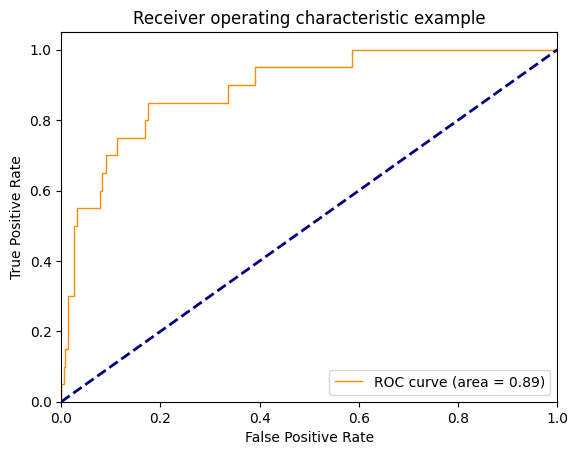

In [306]:

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
roc_auc = roc_auc_score(y_test, pred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [307]:
# Modelo Support Vector Machine
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelo = SVC(
        kernel='rbf',
        C=7,
        gamma=1,
        random_state=42,
        probability =True
    )

    # Treinar o modelo
modelo.fit(X_train_scaled, y_train)

    # Fazer previsões
predicted = modelo.predict_proba(X_test_scaled)[:, 1]
pred = modelo.predict(X_test_scaled)
cm= confusion_matrix(y_test, pred)
print(cm)
    # Avaliar o modelo usando o Brier Score
brier = brier_score_loss(y_test, predicted)

print("Brier Score: ", brier)

[[385   4]
 [ 18   2]]
Brier Score:  0.04334984894214012


'n_estimators': 284, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'auto'

In [308]:
# Treinar o modelo final com os melhores hiperparâmetros

best_model = RandomForestClassifier(
    n_estimators= 284,
    max_depth= 32,
    min_samples_split= 7,
    min_samples_leaf=3,
    max_features='auto',
    random_state=9,
    class_weight={0: 1, 1: 11}
)

# Ajustar o modelo final
best_model.fit(X_train_selected, y_train)

# Avaliar o modelo final
y_pred_prob = best_model.predict_proba(X_test_selected)[:, 1]
predicted6= best_model.predict(X_test_selected)
final_brier_score = brier_score_loss(y_test, y_pred_prob)
print("Final Brier score: ", final_brier_score)
cm= confusion_matrix(y_test, predicted6)
print(cm)



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Final Brier score:  0.03406836426291649
[[383   6]
 [ 13   7]]


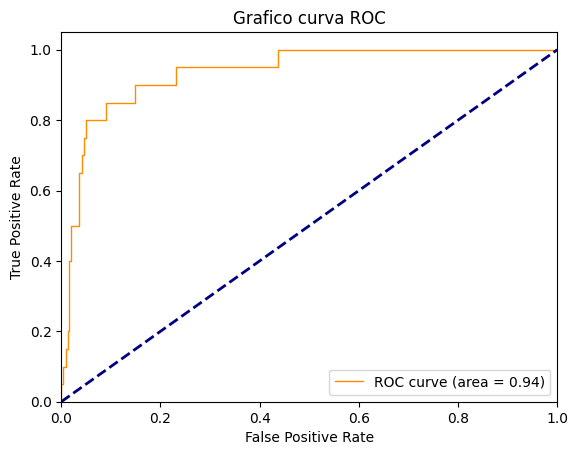

In [309]:


# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Grafico curva ROC')
plt.legend(loc="lower right")
plt.show()

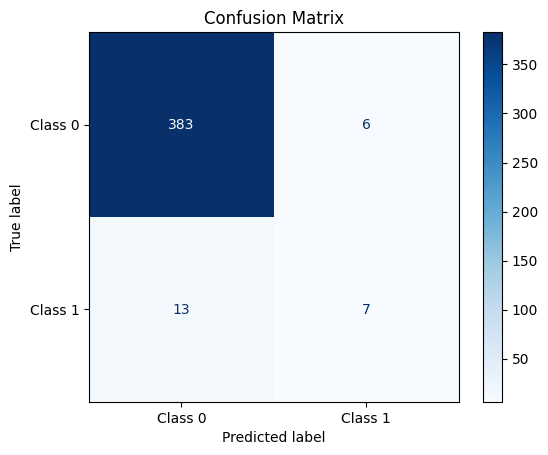

In [310]:
conf_matrix = confusion_matrix(y_test, predicted6)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])

# Plotar a matriz de confusão
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

- Mexendo no threshold do modelo

In [311]:
new_predictions = (y_pred_prob > 0.2).astype(int)

# Print the new predictions
cm= confusion_matrix(y_test, new_predictions)
print(cm)

[[363  26]
 [  4  16]]


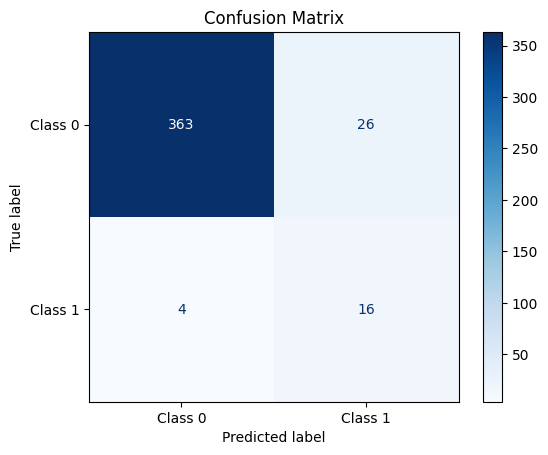

In [312]:
conf_matrix = confusion_matrix(y_test, new_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])

# Plotar a matriz de confusão
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()